学籍番号，氏名を記入して下さい．

# 第12回課題（主成分分析をしてみよう）  
numpy を使って主成分分析をしてデータの次元圧縮をし，結果をmatplotlib を使って2次元のグラフにプロットしてみましょう．

## 必要なモジュールの読み込み  
今回はnumpy とmatplotlib を使います．また，データの読み込みのためにpickle を使うので合わせて読み込みしておきます．

In [1]:
#必要なモジュールを読み込む
import numpy as np
import matplotlib.pyplot as plt
import pickle

## データの読み込み  
データを読み込みます．今回はCIFAR-10 という画像データベース(https://www.cs.toronto.edu/~kriz/cifar.html) を使います.  
すべてのデータを使うとデータ量が莫大なので，10000枚だけ（data_batch_1）を使います．  

**labels** には画像のラベル（0~9までの10種類．対応するカテゴリはlabel_name に保存されている）が格納されています．10000 枚画像があるので，10000次元のベクトルとして表現されています．  

**images** には画像のデータが格納されています．画像は，RGB 3チャネル，32X32 pixelsで，3072次元の横ベクトルとして表現されています．それが画像枚数分あるので，images の次元数は(10000, 3072) になっています．

つまり，i番目のデータのラベルは``labels[i]``で，その画像の横ベクトルは``images[i, :]`` で表現することになります．

In [2]:
#データを読み込む関数．
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

#クラスの番号とクラスの名前の対応（cifer 10 のページから適当に取って来て作った）
label_name =[ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] 

#画像読み込み
cifer_dict = unpickle( './data_batch_1')

#扱いやすいようにリストはndarray 配列として代入．
labels = np.array( cifer_dict[b'labels'] )
#images はndarray 配列なのでそのまま代入
images = cifer_dict[ b'data']

試しにlabels とimages の次元数を出力してみましょう．

In [3]:
print( 'labels.shape = ' + str( labels.shape ) )
print( 'images.shape = ' + str( images.shape ) )

labels.shape = (10000,)
images.shape = (10000, 3072)


また，データの画像がどんなものか見てみましょう．data_num に0~9999までの値を入れてやると，該当するデータのクラスと画像が出力されます．適当に値を代入して，どのようなデータがあるか見て下さい．

airplane


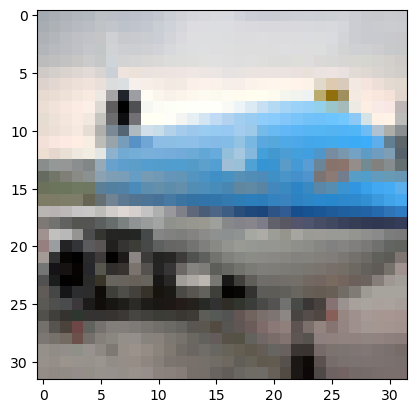

In [4]:
#データの一部を表示
data_num = 700
plt.clf()
plt.imshow( images[data_num].reshape(3, 32, 32).transpose( 1, 2, 0 ) )
print(  label_name[  labels[data_num] ] )

## numpy を使ってPCA を実装
ここから皆さんにコードを書いてもらいます．上で用意されたlabels, images に保存されたデータを用いてPCA を行ってもらい，第一主成分と第二主成分で張られる2次元空間に画像のベクトルを写像してもらいます．そして，写像した結果をmatlpotlib でプロットして表示して下さい．  
（sklearn 使えばいいじゃん，と思われる方もおられるかと思いますが，今回はnumpy を使った演習なので，使わずに実装してみましょう．sklearn は来週使ってもらう予定です．）


### データの標準化
まずは，データの標準化をします．
ここで，サンプル集合$X$を
$$ X = \left[\boldsymbol{x}_1, \boldsymbol{x}_2, \ldots, \boldsymbol{x}_i, \ldots, \boldsymbol{x}_n\right]^{\top}, \boldsymbol{x}_i\in\mathbb{R}^D$$
とします． ちなみに，今回のデータでは$n=10000, D=3072$です．  
標準化はデータの各次元の平均を$0$, 分散を$1$にして，データの偏りをなくし，計算をしやすくするために行います．  
いま，サンプル集合の$j$次元目の平均を$\bar{x}_j$，標本標準偏差を$\sigma_j$とすると，標準化されたサンプル$\boldsymbol{x}^{s}_{i} = \left(x^{s}_{i, 1},x^{s}_{i, 2}, \ldots, x^{s}_{i, j},  \ldots, x^{s}_{i, D}\right)^{\top}$ の$j$次元目の要素$x^{s}_{i, j}$は以下のように表現されます．  
$$x^{s}_{i, j} = \frac{x_{i,j}-\bar{x}_j}{\sigma_j}$$
ただし，$\bar{x}_j$, $\sigma_j$は以下のように計算されます．
$$
\begin{align}
\bar{x}_j &= \frac{1}{N}\sum_{i=0}^{n}x_{i,j}\\
\sigma_j &=\sqrt{\frac{1}{N}\sum_{i=0}^{n}\left(x_{i,j}-\bar{x}_j\right)^2}
\end{align}
$$
標準化を行ったサンプル集合$X^{s}=\left[\boldsymbol{x}^{s}_1, \boldsymbol{x}^{s}_2, \ldots, \boldsymbol{x}^{s}_i, \ldots, \boldsymbol{x}^{s}_n\right]^{\top}$に対してPCA を適用します．  

以下では，まず始めにサンプルのデータを浮動小数点型に変換してから，data に代入しています．
このdata を使ってサンプルの平均，標本標準偏差を計算し，標準化を行いましょう．  
以下のコードのNone のところを適切なコードに書き換え，プログラムを完成させて下さい．
デバグのために値やデータの次元数を適宜出力して下さって結構です．
ただし，**計算はfor 文を使わずに行って下さい．for 文を使った場合，減点対象です．**

In [5]:
#data は画像の画素値で0-255 の値で表現されているので，計算のために浮動小数点型に変換しておく．
data = images.astype( 'float32' )
#データの平均
ave = np.mean(data, axis=0)
#標準偏差
sigma = np.std(data, axis=0)
#もとのデータ-平均/標準偏差
data = (data - ave) / sigma

### 分散共分散行列に固有値分解を適用
続いて，PCA をdata に適用します．ここでは，導出やその原理の説明は省略し，計算の方法のみ説明します．PCA の導出や内容の説明を知りたい人は各自で勉強して下さい．おそらく他の科目で出て来ていると思うのでそのあたりはすでに知っていらっしゃると思います．
まず，標準化されたサンプル集合の分散共分散行列$X^s_{\rm{cov}}$は，
$$X_{\rm{cov}} = {X^{s}}^{\top}X^{s}$$
と計算されます．
続いて，$X^s_{\rm{cov}}$を固有値分解して，固有値と固有値ベクトルを計算して下さい．

In [11]:
#分散共分散行列を計算
cov_mat = np.cov(data, rowvar=False)
#固有値分解により，固有値la と固有ベクトルvを計算
la, v = np.linalg.eigh(cov_mat)

### 第一主成分，第二主成分で張られる空間にデータを投影
固有値を$\lambda_{1}, \lambda_{2}, \ldots, \lambda_{D}, (\mbox{但し}\lambda_{1}\geq\lambda_{2}\geq\cdots\geq\lambda_{D})$，固有値にそれぞれ対応する固有ベクトルを$\boldsymbol{v}_1, \boldsymbol{v}_2, \ldots, \boldsymbol{v}_D$とすると，第一主成分の固有値ベクトルは$\boldsymbol{v}_1$，第二主成分の固有値ベクトルは$\boldsymbol{v}_2$で表現されます．$\boldsymbol{v}_1, \boldsymbol{v}_2$で張られる2 次元空間にデータを投影し，データの次元を2次元に圧縮してみましょう．  
$V_2=\left[\boldsymbol{v}_1, \boldsymbol{v}_2\right]$とすると，データ$X^{s}$の$\boldsymbol{v}_1, \boldsymbol{v}_2$で張られた空間への写像$f_{V_2}(X^s)$は，
$$ f_{V_2}(X^s)= X^{s}V_2$$
で計算されます．
まず，$V_2$にあたる行列を作り，それを用いて上記の写像を計算して下さい．

In [12]:
#V_2 を作成
V2 = v[:, :2]
#V_2 で張られる空間にデータを投影（写像の計算）
projected_data = np.dot(data, V2)

### 2次元空間のデータをプロット
2次元空間上に投影されたデータをプロットしてみましょう．  
x 軸を第一主成分，y軸を第二主成分として，**クラスごとに別の色を使って**最初の1000個のデータ（全部だと量が多いので）をプロットし，``plt.show()`` を使って表示させて下さい．  
描画するグラフは，以下の様式に従って下さい（**守らないと減点対象です**）．  
- 軸のラベル（第一主成分，第二主成分）を必ずつける．（日本語でも英語でも構わない．）  
- クラスの凡例をつける  
- 凡例にはクラスのそれぞれの名称（airplane, automobileなど，クラスの番号との対応はlabel_nameに格納されている．）を表示させる  
- 凡例はグラフの外に表示させる．

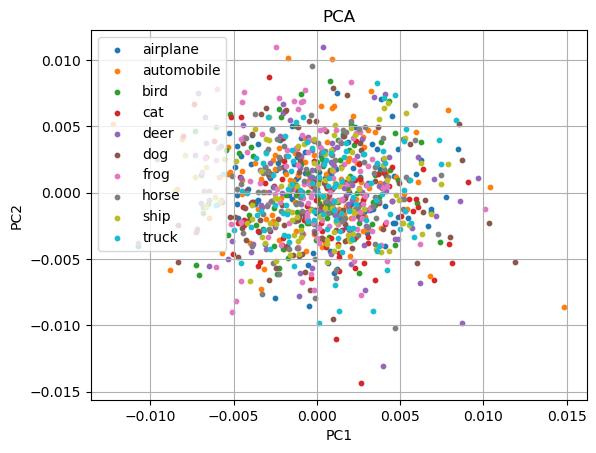

In [15]:
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
sub_data = projected_data[:1000]
sub_label = labels[:1000]
for i, name in enumerate(label_name):
    plt.scatter(sub_data[sub_label==i, 0], sub_data[sub_label==i, 1], label=name, marker = 'o', s=10)

plt.legend(loc = 'upper left', fontsize=10)
plt.show()

### 講義・課題に関する感想  
以下に今回の課題に関しての感想や工夫した点を記入して下さい．

In [ ]:
プロットのサイズが大きすぎて見にくかったので、小さくして見やすくしました！

**課題お疲れ様でした!!!**  
すべてのセルを実行して保存し，ファイル名のXXX の部分を自分の学籍番号に書き換えて，.ipynbファイルを[moodle](https://lms.omu.ac.jp/mod/assign/view.php?id=891774)に提出して下さい．締切は7/19 23:59 です．